In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import moments, moments_central
from astropy.visualization import ZScaleInterval
from astropy.table import Table
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
import data_process_utils as dpu


In [ ]:
coadd = afwImage.ExposureF('fwhm_0607/coadd_grid_exp.fits')
coadd_img = coadd

In [2]:
interval = ZScaleInterval()

In [3]:
def display_exp(exp, frame=None):
    afwDisplay.setDefaultBackend('matplotlib')
    display = afwDisplay.Display(frame=frame)
    display.mtv(exp)    
    return exp

In [4]:
def exp_dict(exp_dir):
    dia_dict = {}
    coadd_path = os.path.join(exp_dir, 'coadd_grid_exp.fits')
    calexp_path = os.path.join(exp_dir, 'var_0_tcat_exp.fits')
    diff_path = os.path.join(exp_dir, 'var_0_tcat_dia_exp.fits')
    diaSrc_path = os.path.join(exp_dir, 'var_0_tcat_dia_src.fits')
    
    coadd_exp = afwImage.ExposureF(coadd_path)
    calexp_exp = afwImage.ExposureF(calexp_path)
    diff_exp = afwImage.ExposureF(diff_path)
    diaSrc = Table.read(diaSrc_path)
    
    calexp_warped = dpu.warp_to_exposure(calexp_exp, coadd_exp)
    diff_warped = dpu.warp_to_exposure(diff_exp, coadd_exp)
    
    coadd_wcs =  coadd_exp.getWcs()
    coadd_bbox = coadd_exp.getBBox()
    
    ra_arr = np.rad2deg(diaSrc['coord_ra'].data)
    dec_arr = np.rad2deg(diaSrc['coord_dec'].data)
    pixel_coord = dpu.skycoords_to_pixels(ra_arr, dec_arr, coadd_wcs)
    pixel_coord = np.array(pixel_coord)   

    if len(pixel_coord) == 0:
        diaSrc['dia_x_in_coadd'] = np.repeat(None, len(diaSrc))
        diaSrc['dia_y_in_coadd'] = np.repeat(None, len(diaSrc))
    else: 
        diaSrc['dia_x_in_coadd'] =  pixel_coord[:, 0]
        diaSrc['dia_y_in_coadd'] =  pixel_coord[:, 1]
    
    dia_dict['coadd'] = coadd_exp
    dia_dict['calexp'] = calexp_warped
    dia_dict['diff'] =   diff_warped
    dia_dict['diaSrc'] = diaSrc
    dia_dict['wcs'] = coadd_wcs
    dia_dict['bbox'] = coadd_bbox
    
    return dia_dict

def get_inj_xy(coadd_wcs, coadd_bbox):
    l = 10
    max_ra = 20.03
    min_ra = 19.97
    min_dec = 0.03
    max_dec = -0.03

    inj_ra_arr = np.linspace(min_ra, max_ra, l)
    inj_dec_arr = np.linspace(min_dec, max_dec, l)
    
    x_list = []
    y_list = []
    for ra, dec in zip(inj_ra_arr, inj_dec_arr):
        x, y = dpu.radec2xy(ra, dec, coadd_wcs)
        dx = x - coadd_bbox.beginX
        dy = y - coadd_bbox.beginY
        x_list.append(x)
        y_list.append(y)
    return x_list, y_list

In [13]:
dia = exp_dict('./devel/broad/')
xx, yy = get_inj_xy(dia['wcs'], dia['bbox'])
diaSrc = dia['diaSrc']

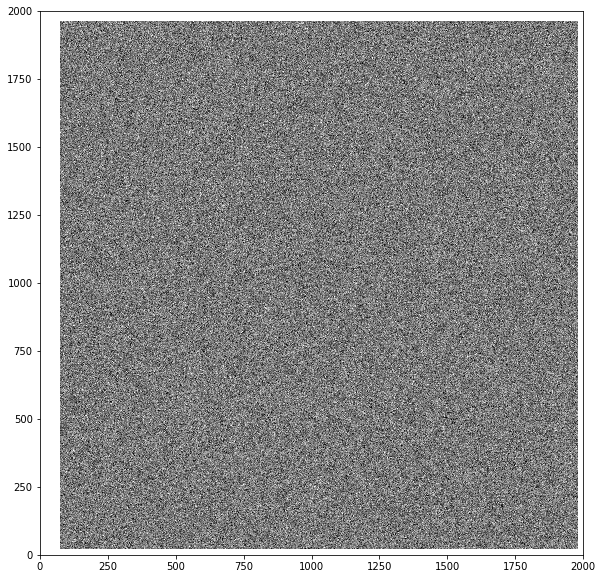

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
data = dia['diff'].getImage().array
ax.imshow(interval(data), origin='lower', cmap='gray')
plt.savefig('./devel/f1e7_braod.png',dpi=100)


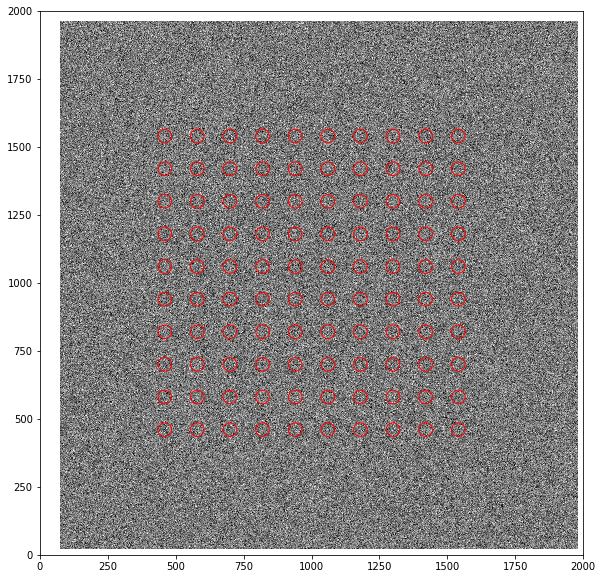

In [18]:

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(interval(dia['diff'].getImage().array), origin='lower', cmap='gray')

for x in xx:
    for y in yy:
        circ = plt.Circle((x, y), 25, color='r', fill=False)
        ax.add_patch(circ)
for row in diaSrc:
    x, y = row['dia_x_in_coadd'], row['dia_y_in_coadd']
    circ = plt.Circle((x, y), 25, color='g', fill=False)
    ax.add_patch(circ)
# ax.set_title(title)
        
plt.savefig('./devel/f1e7_broad.png',dpi=100)

print()

In [120]:
ccyy = dia['calexp'].getPsf()

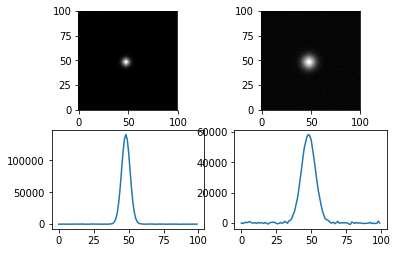

In [14]:
fig, ax = plt.subplots(2,2)

x, y = xx[0], yy[0]
coadd_cutout =  dpu.make_cutout(dia['coadd'], x, y, cutout_size=100)
calexp_cutout = dpu.make_cutout(dia['calexp'], x, y, cutout_size=100)
diff_cutout = dpu.make_cutout(dia['diff'], x, y, cutout_size=100)
    
ax[0][0].imshow(coadd_cutout.getImage().array, origin='lower', cmap='gray')
ax[0][1].imshow(calexp_cutout.getImage().array, origin='lower', cmap='gray')

ax[1][0].plot(coadd_cutout.getImage().array[:,50])
ax[1][1].plot(calexp_cutout.getImage().array[:,50])

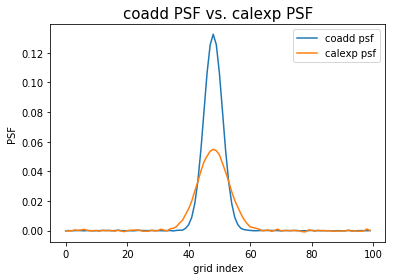

In [15]:
plt.plot(coadd_cutout.getImage().array[:,50] / np.sum(coadd_cutout.getImage().array[:,50]), label='coadd psf')
plt.plot(calexp_cutout.getImage().array[:,50] / np.sum(coadd_cutout.getImage().array[:,50]), label='calexp psf')
plt.legend()
plt.title('coadd PSF vs. calexp PSF', size=15)
plt.xlabel('grid index',size=10)
plt.ylabel('PSF',size=10)
plt.savefig('./devel/psf_broad.png', dpi=100)

In [139]:
dia = exp_dict('./devel/rtestf1e7/')
xx, yy = get_inj_xy(dia['wcs'], dia['bbox'])
# diaSrc = dia['diaSrc']

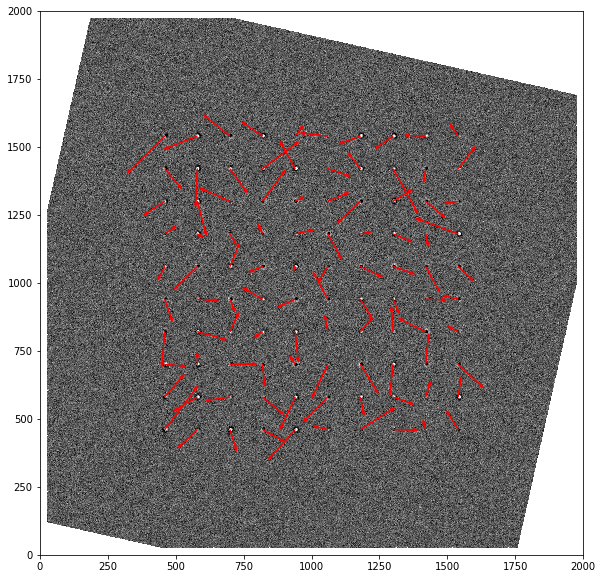

In [144]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(interval(dia['diff'].getImage().array), origin='lower', cmap='gray')
for x in xx:
    for y in yy:
        circ = plt.Circle((x, y), 10, color='r', fill=False)
        # ax.add_patch(circ)
        cutout =  dpu.make_cutout(dia['diff'], x, y, cutout_size=100)
        image_arr = cutout.getImage().array
        mo = moments(np.abs(image_arr))
        # xc, yc = mo[1, 0] / mo[0, 0], mo[0,1] / mo[0, 0]
        xc, yc = 50, 50
        mo_c = moments_central(image_arr, (xc, yc), 1)
        delta_x, delta_y = mo_c[1, 0] / 25000, mo_c[0,1] / 25000
        ax.arrow(x, y, delta_x, delta_y, head_width=10,color='red')
plt.savefig('vec.png',dpi=100)

# FFT

In [5]:
from numpy.fft import fft2, fftshift

In [6]:
dia = exp_dict('./devel/r0f1e7/')
xx, yy = get_inj_xy(dia['wcs'], dia['bbox'])
diaSrc = dia['diaSrc']

In [7]:
diff = dia['diff'].getImage().array
diff = diff[200:-200, 200:-200]

In [8]:
xx, yy, dia['diff'].getImage().array.shape

([1540, 1420, 1300, 1180, 1060, 940, 820, 700, 580, 460],
 [1540, 1420, 1300, 1180, 1060, 940, 820, 700, 580, 460],
 (2000, 2000))

In [203]:
# plt.figure(figsize=(10,10))
# plt.imshow(interval(diff), cmap='gray', origin='lower')

In [9]:
diff_f = fft2(diff)

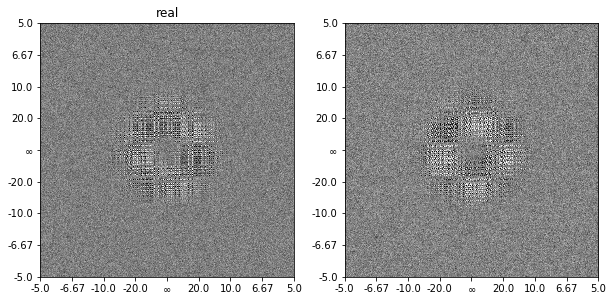

In [10]:
pix_arr =  np.round(2000 / np.array([100, 200, 300, 400]), decimals=2).astype(float)                     
ticks = list(-np.flip(pix_arr)) + [r'$\infty$'] + list(pix_arr) 

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust()
ax[0].imshow(interval(fftshift(diff_f.real)[400:-400, 400:-400]),
             origin='lower', cmap='gray')
ax[0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[0].set_xticklabels(ticks)
ax[0].set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[0].set_yticklabels(ticks)
ax[0].set_title('real')
ax[1].imshow(interval(fftshift(diff_f.imag)[400:-400, 400:-400]),
             origin='lower', cmap='gray')
ax[1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[1].set_xticklabels(ticks)
ax[1].set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[1].set_yticklabels(ticks)
print()

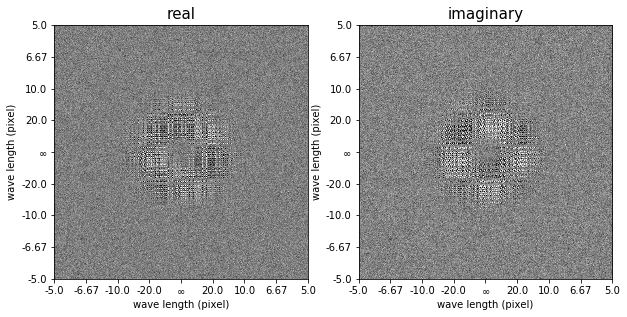

In [12]:
pix_arr =  np.round(2000 / np.array([100, 200, 300, 400]), decimals=2).astype(float)                     
ticks = list(-np.flip(pix_arr)) + [r'$\infty$'] + list(pix_arr) 

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust()
ax[0].imshow(interval(fftshift(diff_f.real)[400:-400, 400:-400]),
             origin='lower', cmap='gray')
ax[0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[0].set_xticklabels(ticks)
ax[0].set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[0].set_yticklabels(ticks)
ax[0].set_title('real', size=15)
ax[0].set_xlabel('wave length (pixel)', size=10)
ax[0].set_ylabel('wave length (pixel)', size=10)
ax[1].imshow(interval(fftshift(diff_f.imag)[400:-400, 400:-400]),
             origin='lower', cmap='gray')
ax[1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[1].set_xticklabels(ticks)
ax[1].set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax[1].set_yticklabels(ticks)
ax[1].set_title('imaginary', size=15)
ax[1].set_xlabel('wave length (pixel)', size=10)
ax[1].set_ylabel('wave length (pixel)', size=10)
plt.savefig('./devel/fft.png', dpi=100)
print()

In [ ]:
plt.plot(fftshift(diff_f.real))